# QuaSaR: Identifying EEW Rings

## GOAL AND OBJECTIVES
Quake Shielded Rings (QuSaR) are essentially self relient [Rings](https://brilliant.org/wiki/ring-theory/) of sensors sharing discretized time-series of wave form information to identify threats and forewarn to give man and machine a lead time to respond to harmful earthquakes.

The overall __gaol__ is to examine how the GeoNet seismic network can be augmented with a low-cost network to offer low-latency EEWs by making use of cutting-edge earthquake picking algorithms and machine learning techniques. The expected outcome is for the findings to serve as evidence for supporting a strategic deployment of a ring or rings of micro-array networks. 

The intent is to also make use of the analysis and tools is to serve as inputs for earthquake hazard risk assessment. Thereby, a community interested in operationalizing their own micro-array ring can mae us of the analysis and tools to determining whether or not and how they may need to invest in building a micro-array ring.

### Objectives
1. _Understand the network dynamics (structure of connection of the units and their capabilities)_
   1. Retrieve data on all the operational NZ seismic stations to __map the inventory__ by types and location.
   1. Build a __nearest neigbour map of clusters__ of all the operational stations within a 30Km radius
   1. Determine station cluster __topography__ relative to the __fault lines__ and earthquake detection role and capacity  
1. _Apply earthquake __picking algorithms__ on the GeoNet wave form data_
   1. Test the __standard GeoNet algorithms__ (e.g. LTS/STS, Pd, )
   1. Test with new __machine learning and wavefield algorithms__ (e.g. , PLUM)
   1. Test above picking algorithms with __simulated earthquakes__ and for __selected high risk faults__ to observe the response of the picking algorithms
   
1. _Determine ways for improving the station rings for an incremental effectiveness of EEW_
   1. Propose to __fit additional stations__ to improve the 30Km nearest neighbour cluster; then show how that improves the picking
   1. Apply the geodedic methodology to __interpolate seismic data__ for the proposed station locations 
   1. Try the earthquake __picking algorithms__ on the hypothetical network to measure effectiveness

## OBJECTIVE 1.A - SENSOR MAP

### DEFINE data services and software modules

We make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data. 
1. ObsPy
   1. FSDN as Client data sources; both (i) the FDSN client service and the (ii) FDSN complient GoeNet API webservice
   1. Core to read data and utilize datatime features
   1. Picking algorithms
1. FDSN station service
   1. retrieve station metadata information in a FDSN StationXML format or text format for all the channels in CECS station with no time limitations: https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel&format=text


In [1]:
import glob
from obspy import read_inventory
from obspy.clients.fdsn import Client
from obspy.core import read, UTCDateTime
#from datetime import date

# Establish start and end time for retrieving waveform data
t_start = UTCDateTime.now()-518400 #6 days ago = 60s x 60m x 24h x 6d
t_end = UTCDateTime.now()+86400 #1 day in the future = 60s x 60m x 24h
print('Station startime: ', t_start, '\n & ending time: ', t_end)

try:
    #use either or GeoNet station service webservice URL or Obspy FDSN Client protocol to retrieve station data
    st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&level=station&endafter=2020-12-31&format=xml'
    #st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel'
    # Set FDSN client URL to arc_client
    client  = Client('GEONET')
    print("Client is",client)
except Exception as err:
    print("Error message:", err)


Station startime:  2020-10-20T05:54:48.696668Z 
 & ending time:  2020-10-27T05:54:48.697085Z
Client is FDSN Webservice Client (base url: http://service.geonet.org.nz)
Available Services: 'dataselect' (v1.1), 'event' (v1.1), 'station' (v1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


### Get all Station details

An initiatl step for object 1.A is determining the the types of operational seismic sensors and their locations. GoeNet hosts wave forms for a multitude of [sensor types](https://api.geonet.org.nz/network/sensor/type) (e.g. tidle guages, pressure gauges, seismometers, GNSS antennas, barometers, Microphones, Hydrophones and so on). The focus is on motion sensors of type: (i) accelerometer, (ii) broadband velocity, (iii) short period velocity, and (iv) GNSS. Furthermore, the sensors location code is unique to each sensor type. Therefore, one may chose to use the location code prefix or sensor type enumerator to select the desired sensors; i.e. seimograph and accelerometer stations. The motion sensors are used in both earthquake and volcanic seismic activity monitoring and early warning.

_Sensor types that are relevant to earthquake detection are:
* 1 Accelerometer 
* 3 Broadband Seismometer 
* 4 GNSS Antenna 
* 8 Short Period Borehole Seismometer 
* 9 Short Period Seismometer 
* 10 Strong Motion Sensor

_Location codes reserved for the seismic sensors are:_
* 1? - weak motion sensors
* 2? - strong motion sensors

_Channel codes are:_ 
- First letter of the code represents a combination of sampling rate and sensor bandwidth
* U (Ultra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz)
* V (Very Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz)
* L (Broad band sampled at 1Hz, or SOH sampled at 1Hz)
* B (Broad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz)
* S (Short-period sampled at between 10 and 80 Hz, usually 50 Hz)
* H (High Broad band sampled at or above 80Hz, generally 100 or 200 Hz)
* E (Extremely Short-period sampled at or above 80Hz, generally 100 Hz)

- The second letter represents the sensor type, e.g.(listed are the ones relevant to seismometers
* H (Weak motion sensor, e.g. measuring velocity)
* N (Strong motion sensor, e.g. measuring acceleration)
* L (Low gain sensor, usually velocity)
* M (Mass position, used for monitoring broadband sensors)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Number of active stations: 453


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


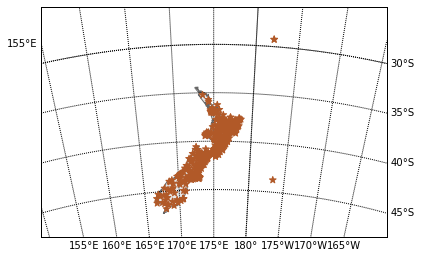

In [42]:
try:
    #st_inv = read_inventory(st_ws)
    st_inv = client.get_stations(network='NZ', location="1?,2?", station='*', channel='U*,V*,L*,B*,S*,H*,E*', 
                                 level='station', starttime=t_start, endtime = t_end)
    #Print the station inventory
    print('Number of active stations:', len(st_inv[0].stations))
    '''
    i = 0
    for i in range(len(st_inv[0].stations)):
        #print('Code:',st_inv[0][i].code,'Latitude:',st_inv[0][i].latitude,'Longitude:',st_inv[0][i].longitude,'Elavation:',st_inv[0][i].elevation)
        print(st_inv[0][i])
    '''
    #Plot network
    st_inv.plot(projection="local", resolution="l", continent_fill_color='0.9', water_fill_color='1.0', 
                   marker='*', size=50, label=True, color='#b15928', time=None, show=True, outfile=None, 
                   method=None, fig=None)

except Exception as err:
    print("Error message:", err)


### Stataions array data preperation

Prepare an array of tuples necessary and sufficient station data:
* _station code_ as a unique identifier
* _coordinates_ longitude & latitude
* _elevation_ in meters above mean sea level

In [50]:
import numpy as np

st_coord = []

try:
    i = 0
    for i in range(len(st_inv[0].stations)):
        st_tuple = (st_inv[0][i].code, st_inv[0][i].latitude,st_inv[0][i].longitude, st_inv[0][i].elevation)
        st_coord.append(tuple(st_tuple))
        #st_coord = {'Code': st_inv[0][i].code,'Coordinates': {'Latitude': st_inv[0][i].latitude,'Longitude': st_inv[0][i].longitude},'Elavation': st_inv[0][i].elevation}
#        print(st_coord[i])

    # Remove unnessary columns
    tmp_nolabel_arr = np.delete(st_coord, [0,3],axis=1).astype(np.float)
    print('number of station coordinates:',len(tmp_nolabel_arr))
    print('Station coordinates:\n',' '.join([str(elem) for elem in tmp_nolabel_arr])) 

# Mapping stations
except Exception as err:
    print("Error message:", err)

number of station coordinates: 453
Station coordinates:
 [ -36.600224    174.83233291] [ -43.9024444   171.74756295] [ -43.8721   172.90983] [ -43.81091  172.96349] [ -38.5620433   176.34301405] [ -43.15467772  172.73087951] [ -43.17654  172.65146] [ -40.45974293  176.4750588 ] [ -42.94894944  171.5677355 ] [ -46.83180552  167.9888255 ] [ -38.62769  176.12006] [ -43.94705  171.17674] [ -39.2631  176.9959] [ -41.24207703  174.94409642] [ -42.52395847  171.40786558] [ -43.27441041  172.59594718] [ -37.06378  174.64292] [ -46.24906366  169.71937268] [ -40.67964728  176.2462451 ] [ -39.489284   176.0629288] [ -41.40823068  174.87111481] [ -39.16566564  176.49254374] [ -41.191372  174.92603 ] [ -41.279193  174.776323] [ -41.71491545  173.87574085] [ -41.38923599  173.12851282] [ -43.480415   172.6821837] [ -41.43954404  173.90511789] [ -43.48317558  172.53001529] [ -41.10719423  175.06643852] [ -43.52934701  172.61987624] [ -43.538085  172.647427] [ -42.81349055  173.27486818] [ -39.6581870

### Fault line map

We have completed objective 1.A. However, we will also include a mapping of the fault lines to give a perception of the station distribution relative to that of the map of fault lines. 

In [4]:
import matplotlib.pyplot as plt 
import json

"""Extract nested values from a JSON tree."""

##try:
with open('/home/nuwan/workspace/quasar/data/NZAFD/JSON/NZAFD_Aug_2020_WGS_84.json') as json_file: 
    data = json.load(json_file)
        
print(data.features)

points = {"x":[], "y":[]}
for features in data['features']:
    for geometry in features['geometry']:
        print(geometry)
#        for paths in range(len(geometry)):
#            print(geometry[paths])
#            for coordinates in paths:
#                print(coordinates)
#                points["x"].append(coordinate[0])
#                points["y"].append(coordinate[1])
#plt.plot(points["x"],points["y"])

##except Exception as err:
##    print("Error message:", err)

AttributeError: 'dict' object has no attribute 'features'

In [5]:
import pygeoj

try:
    faults_file = pygeoj.load(data=dict(
        filepath='/home/nuwan/workspace/quasar/data/NZAFD/JSON/NZAFD_Aug_2020_WGS_84.json'))
except Exception as err:
    print("Error message:", err)

Error message: The FeatureCollection needs to contain a 'features' property


Error message: readshapefile can only handle 2D shape types


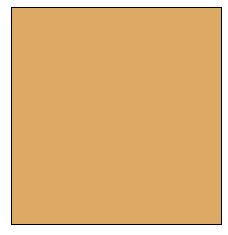

In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, shape, Point

map = Basemap(llcrnrlon=-41.,llcrnrlat=75.,urcrnrlon=-39.,urcrnrlat=78.,
             resolution='l', projection='tmerc', lat_0 = -40, lon_0 = 176)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#ddaa66',lake_color='aqua')
#map.drawcoastlines()

try:
    map.readshapefile('/home/nuwan/workspace/quasar/data/NZAFD/Shapefile/NZAFD_Aug_2020',
                      'ative_faults', 
                      drawbounds=True)

    plt.show()
except Exception as err:
    print("Error message:", err)

## OBJECTIVE 1.B - STATION CLUSTERS

### Cluster Stations

Apply DBSCAN to cluster stations with an epsilon < 30Km. DBSCAN is preferred over K-means clustering because K-means clustering considance the variance while DBSCAN considers a distance function. It gives the capacity to build clusters serving the criteria of < 30Km distance between stations.

#### Data clensing

#### Cluster
1. Apply DBSCAN
   1. Inherent __problem of DBSCAN__ is that it characterises data points to be in the same clusted if pair-wise data points satisfy the epsilon condition. This would not adequately satisfy the required condition that all data points in a a cluster are within the desired epsilon distance.
1. Compute the cluster property measures to estimate the acceptability
1. Dump the output to a file including cluster label, lat/lon, station code, and so on

In [31]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

def get_dbscan_labels(st_arr):
    err="0"
    try:
        X, labels_true = make_blobs(n_samples=len(st_arr), centers=st_arr, cluster_std=0.4,random_state=0)
        db = DBSCAN(eps=30.0/6371.0, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
        print('DBSCAN epsilon:',db.eps,'algorithm:', db.algorithm, 'metric: ', db.metric)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
#        print("DBSCAN found %0.3f labels" % labels )
    except Exception as err:
        print("Error message:", err)
        labels = ""
    return labels, labels_true

### Parametric analysis of the clusters

A large propotion of the sensors could be clustered to have, at least, 03 senors in a cluster and that they are < 30Km distance from each other; which also is the basis for the ```eps = 30.0/6371.0``` (epsilon convereted to radians using the length of Earth's radius 6371Km). The estimated number of _noise points_ tell us the number of sensors that didn't belong to any cluster. The particular geodedic data cannot be clustered with KD-Trees or any Tree algorithm. However, chosing ```algorithm = "ball_tree"``` is recommended as it is well suited for geospatial data clustering. The ```metric = "haversine"``` is naturally required to calculate the distance between two geographical points. Finally, the ```st_dbscan_arr``` comprising latitude and longitude decimal data is converted to radians to be consistent with using the _haversine_ distance funcation.

In [32]:
# Run dbscan and get the labels
labels, labels_true = get_dbscan_labels(tmp_nolabel_arr)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Total number of stations: %d' % len(labels))
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plot a histogram of the station distribution

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print(f"Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tmp_nolabel_arr, labels))

DBSCAN epsilon: 0.0047088369172814315 algorithm: ball_tree metric:  haversine
Total number of stations: 453
Estimated number of clusters: 21
Estimated number of noise points: 76
Homogeneity: 0.337
Completeness: 1.000
V-measure: 0.504
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: -0.609


#### Plot results
1. plot clusters with varied colors unique to each cluster
1. plot fault lines to show closes sensor in cluster to the fault line

In [6]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(30, 40))
#nz_map = Basemap(width=1500000,height=1500000,projection='lcc',
#            resolution='l',lat_1=-37.,lat_2=-45,lat_0=-40,lon_0=176.)
#nz_map.drawcoastlines()

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # uncomment to plot the noise
    #xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

NameError: name 'labels' is not defined

<Figure size 2160x2880 with 0 Axes>

### Mean Nearest Neighbour Distance Statistics

Compute the mean distance between nearest neigbours of a minimum 3 points
* https://scikit-learn.org/stable/modules/neighbors.html
* https://pysal.org/notebooks/explore/pointpats/distance_statistics.html#Mean-Nearest-Neighbor-Distance-Statistics

In [5]:
from sklearn.neighbors import NearestNeighbors

# Augment station array with cluster number
# Start a new station coorinates and details tuple
st_list = []
i=0
for i in range(len(labels)):
    st_row = [tmp_arr[i,0],labels[i],tmp_arr[i,1],tmp_arr[i,2],tmp_arr[i,3]]
    st_list.append(list(st_row))

clusters = list({item[1] for item in st_list})

for each_cluster in clusters:
    cluster_list = list(st_list[j] for j in range(len(st_list)) if st_list[j][1] == each_cluster)
    cluster_arr = np.delete(cluster_list, [0,1,4],axis=1).astype(np.float)
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='haversine').fit(cluster_arr)
    distances, indices = nbrs.kneighbors(cluster_arr)
    print(nbrs.kneighbors_graph(cluster_arr).toarray())
    
    each_cluster_clique = client.get_stations(latitude=-42.693,longitude=173.022,maxradius=30.0/6371.0, starttime = "2016-11-13 11:05:00.000",endtime = "2016-11-14 11:00:00.000")
    print(each_cluster_clique)
    _=inventory.plot(projection="local")
    
    break

sorted_rank = sorted(st_list, key=lambda i: (int(i[1])), reverse=True)
#print('Code, Cluster, Latitude, Longitude, Elevation')
#print(sorted_rank)

NameError: name 'labels' is not defined

### Discussion of DBSCAN results
It is evident from the cluster with large volume of data points are spread across the geography. Therefore, DBSCAN is shown to be innopriate for clustering stations to estimate whether they hold the property of being 30Km within each other.

Next we 

## RESOURCES
1. [Global data services and standards](http://www.fdsn.org/services/) offered by the International Federation Data of Seismic Networks (FDSN). 
1. GEONET resources:
   1. [Stream Naming Conventions](https://www.geonet.org.nz/data/supplementary/channels) are based on historical usage together with recommendations from the [SEED manual](https://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf)
   1. [Python tutorials](https://www.geonet.org.nz/data/tools/Tutorials) for using GeoNet resources
1. [Seismo-Live](https://krischer.github.io/seismo_live_build/html/Workshops/2017_Baku_STCU_IRIS_ObsPy_course/07_Basic_Processing_Exercise_solution_wrapper.html) examples of get station waveform, inventory, event, arrival time, response, and plotting using obspy
1. Choosing [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) over KMeans: 
   1. Fundermentally KMeans requires us to first select the number of clusters we wish to find and DBSCAN doesn't.
   1. [clustering to reduce spatial data sizes](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) KMeans is not an ideal algorithm for latitude-longitude spatial data because it minimizes variance, not geodetic distance. 
   1. [Explanation of DBSCAN clustering](https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31) also identifies a drawback of KMeans clustering as it is vulnerable to outliers and outliers have a significant impact on the way the centroids moves.
1. [Example of scikit-learn DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
1. [obspy.geodetics](https://docs.obspy.org/packages/obspy.geodetics.html) - various geodetic utilities for ObsPy - try an alternative clustering method with obspy geodetics
1. Mapping tutorials
   1. Visualization: [Mapping Global Earthquake Activity](http://introtopython.org/visualization_earthquakes.html)
   1. Plotting data on a map [(Example Gallery)](https://matplotlib.org/basemap/users/examples.html)